<a href="https://colab.research.google.com/github/nicolasalarconl/InterferometryDeepLearning/blob/main/Resumen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interferometry

Radio telescopes can be used individually or they can be associated with each other to create a set of telescopes known as an interferometer. In an interferometer, signals from all the telescopes are put together and processed by a correlator, which combines the signals to simulate that they form a much larger telescope.

*Aperture synthesis* or *image synthesis* is a type of interferometry that mixes signals obtained from a set of telescopes to produce images with the same angular resolution, as if it had been obtained by an instrument that had the dimensions of the entire set. 

Resolution is determined by the separation of the elements, rather than the size of the individual elements. By varying the distance between the elements, the "baseline", and their  orientation to the sky, the autocorrelation function of the electromagnetic field can be measured over an area with a diameter up to the longest baseline.


Radio telescopes can be used individually or they can be associated with each other to create a set of telescopes known as an interferometer. In an interferometer the signals from all the telescopes are put together and processed by a correlator, which combines the signals to simulate that they form a much larger telescope.

*Aperture synthesis* or *image synthesis* is a type of interferometry that mixes signals obtained from a set of telescopes to produce images with the same angular resolution, as if it had been obtained by an instrument that had the dimensions of the whole set.

Resolution is determined by the spacing of the elements, rather than the size of the individual elements. By varying the distance between the elements (the "*baseline*"), and their orientation with respect to the sky, the ** autocorrelation function ** of the electromagnetic field can be measured over an area with a diameter up to the baseline. more extensive.

The observed autocorrelation function is the Fourier transform of the sky brightness distribution and the relationship is governed by the Van Cittert-Zernike theorem


$$ V(u,v)= \int \int I(l,m)e^{2\pi i(ul+vm)}dudv $$
$$ I(l,m)= \int \int V(u,v)e^{-2\pi i(ul+vm)}dudv $$

* $I(l,m)$, Represents the intensity distribution in the sky.
* $V(u,v)$,Represents the brightness of the source and its location in spatial frequencies $(u,v)$.

However, what has been described are idealized antennas, because each antenna of an interferometer has a finite diameter. Such antennas have their own power response in the sky $ P_ {N} = A (l, m) $ Therefore, an interferometer actually measures the Fourier transform of the sky brightness distribution multiplied by the power response of the antenna.

$$ V(u,v)= \int \int A(l,m)I(l,m)e^{2\pi i(ul+vm)}dudv $$


To recover the distribution of the sky, the visibility distribution should be measured in its entirety, since an image of the sky is the sum of all the visibilities. And, as the last processing step, it should be divided by $ A (l, m)$.


All the principles described above should allow to recover the true distribution of the brightness of the sky, however, in practice, it is impossible to completely sample the $ uv $ plane and obtain all the visibilities, that is, the autocorrelation function is sampled only in a limited way by what both corresponding to an observed autocorrelation function and cannot be determined in a unique way.

The standard way to obtain an estimate of the sky is to assume that all unobserved parts of the autocorrelation function have zero value.

That is to say, the image obtained from the sampled autocorrelation function is an estimate of the true brightness distribution in the sky, which is known as *Dirty Image*.

# Dirty Image

The point dispersion function B of the visibility distribution is defined as:


$$ B(u,v)  = \sum ^{M}_{K=1} \delta (u-u_k,v-v_k)$$


*   $M$ is the finite number of visibilities.
*   $U_k$ y $V_k$ are the locations of the K-th sample on the fourier plane.




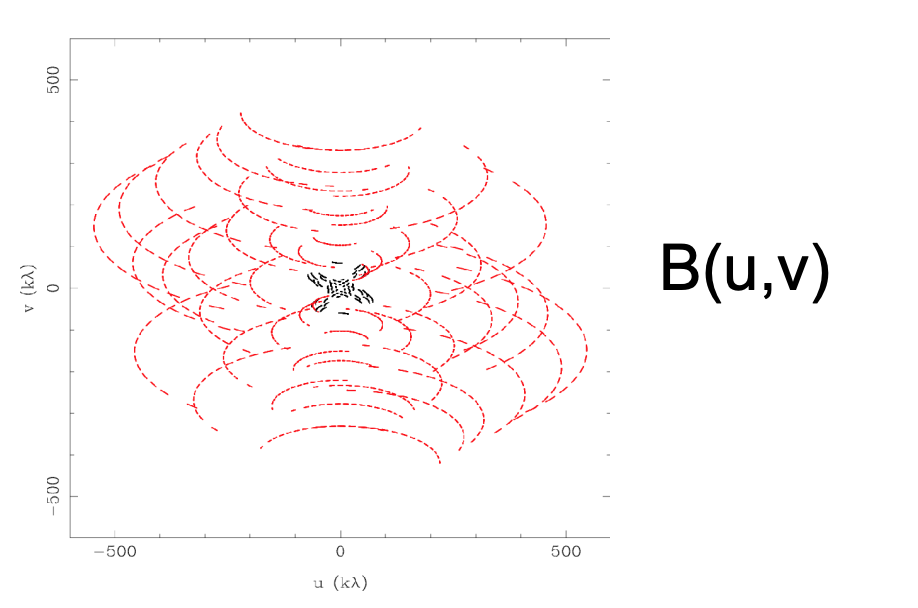

We can define the *** Dirty Image *** as the inverse fourier transform of the sampled visibility.

$$ I^D(l,m) = \int \int B(u,v)V(u,v)e^{i2\pi(ul+um)} dudv $$





Applying the convolution theorem knowing that the inverse fourier transform of $ V $ is the image $ I $, then:

$$ I^D(l,m) =  b(l,m) * I(l,m) $$


We identify $ b $ as the ***Dirty Beam*** (PSF) corresponding to the inverse Fourier transform of $ B $


$$ b(l,m) =  F^{-1} [B(u,v)] $$


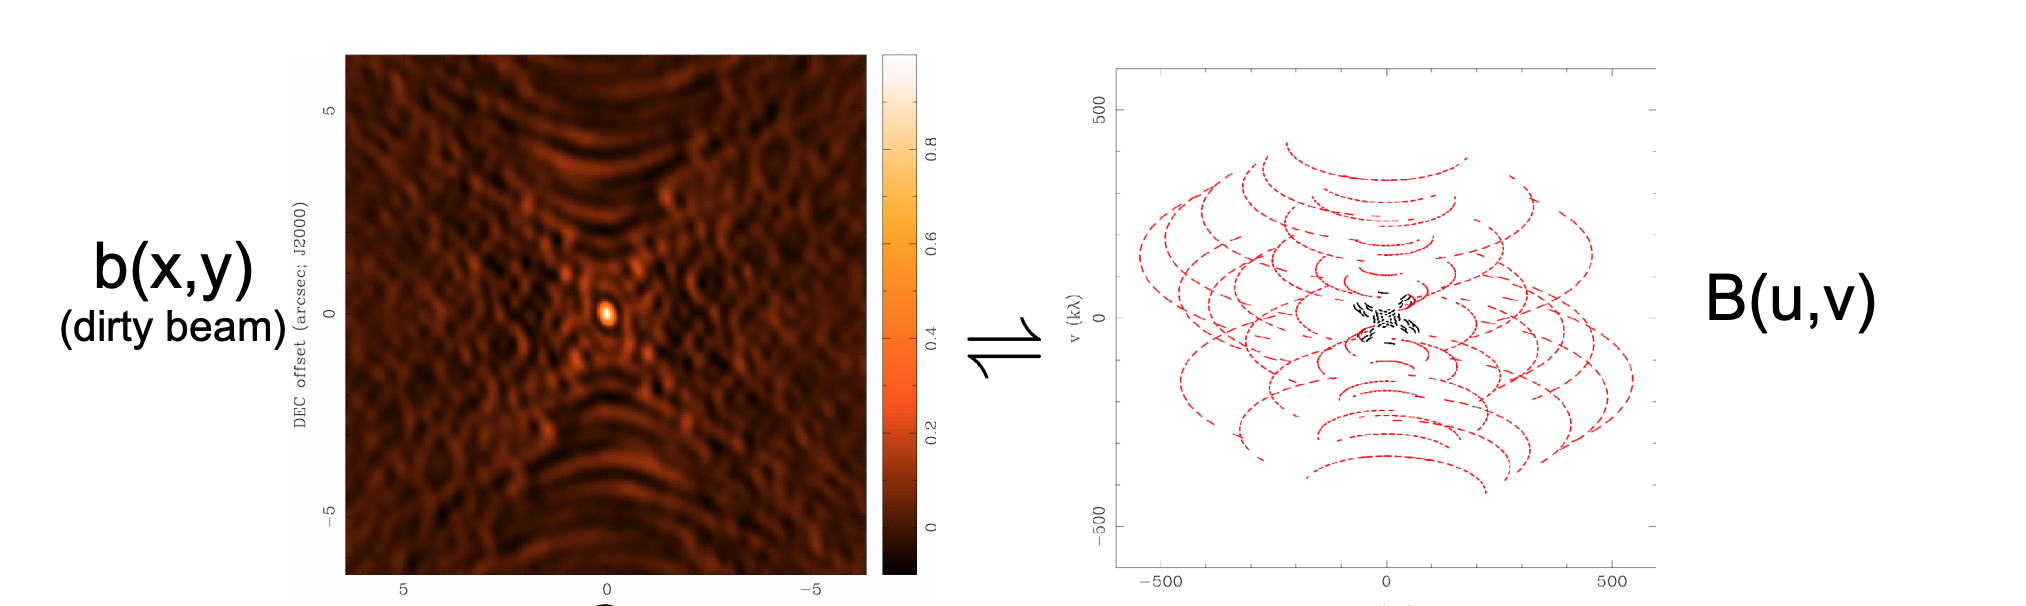

Indeed, Dirty Image $ I ^ D (l, m) $ is the convolution of the true sky brightness distribution $ I (l, m) $ with the point scattering function $ b (l, m) $ ( PSF). When making this estimation, the resulting image has significant artifacts depending on the distribution of the brightness of the sky and the sampling of the plane $ uv $.



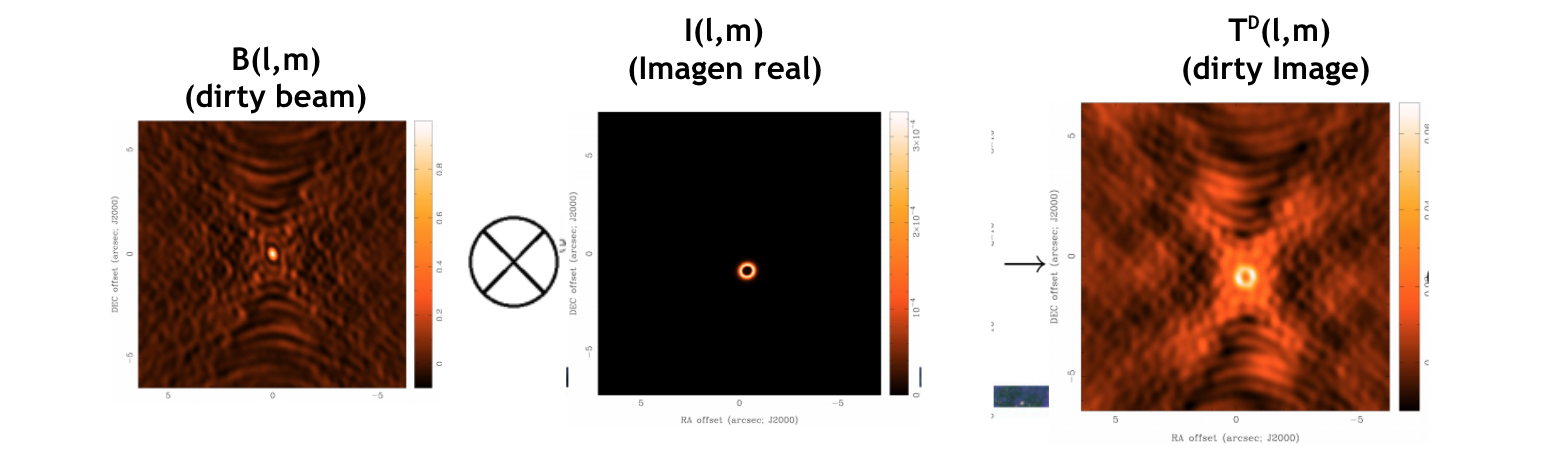

Finally, adding the antenna reception pattern $ A(l,m) $

$$ I^D(l,m) =  b(l,m)\otimes  I(l,m)A(l,m) $$


Then the image synthesis problem corresponds to deconvolve the dirty beam of the dirty image in order to recover the original image.


# Simulate Interferometer (*)

we will carry out a simulation of an interferometer, from the moment the data is captured until the moment the images are obtained. Notebook was created for the CHPC/NITheP 2019 Chris Engelbrecht Summer School on the Foundations of Theoretical and Computational Science. https://github.com/as595/NITheP/blob/master/TUTORIALS/SimulateInterferometer.ipynb

First we import some libraries:

In [1]:
import numpy as np
import pandas as pd
import pylab as pl
import cv2
from PIL import Image
import requests
from io import BytesIO




Then define a constant we're going to use many times:

In [2]:
const_c = 3e8   # speed of light [m/s]

We're going to simulate some data for the VLA telescope in D-array, its most compact configuration. The diameter of a VLA dish is 25m and we're going to simulate a monochromatic observation at a frequency of 5GHz.

In [3]:
D = 25                         # diameter of dish [metres]
frequency = 5e9                # observing frequency [Hz]
wavelength = const_c/frequency # receiving wavelength [metres]

We can work out the reception pattern of an individual dish, known as the *primary beam*, using 

$$ \Delta \theta_{\rm pb} = \frac{\lambda}{D} $$

which returns the angle in radians.

Note: sometimes you will see a pre-factor infront of this equation (e.g. $1.22\,\lambda/D$ or $1.02$ or $1.15$ ...). This pre-factor depends on the illumination of the dish by the receiver, which can be changed by (e.g.) tapering the edges of a parabolic dish.

In [4]:
FoV = wavelength/D              # Field of View [rads]
print('Field of View =', round(FoV*180./np.pi, 2) ,'degrees')

Field of View = 0.14 degrees


Now we should define the distribution of our antennas on the ground. Note that radio astronomers say "antennas" rather than "antennae".

We're going to pretend that we're using the VLA telescope in D-array (most compact configuration). The positions of the antennas are described [here](https://science.nrao.edu/facilities/vla/docs/manuals/oss2016A/ant_positions.pdf). I've provided them as CSV files. The VLA has three "arms": North, South West and South East.

In [5]:
vla_swest = pd.read_csv('https://raw.githubusercontent.com/as595/NITheP/ad4db751f0470fdcacb43f00c5b1d1cb64f8e3fa/TUTORIALS/data/VLA_SWest.csv')
vla_north = pd.read_csv('https://raw.githubusercontent.com/as595/NITheP/master/TUTORIALS/data/VLA_North.csv')
vla_seast =  pd.read_csv('https://raw.githubusercontent.com/as595/NITheP/ad4db751f0470fdcacb43f00c5b1d1cb64f8e3fa/TUTORIALS/data/VLA_SEast.csv')


The positions of the radio antennas are provided in units of nanoseconds. We can convert these into units of number of wavelengths:

$$ b\,{\rm [\lambda]} = 10^{-9}\frac{\rm c}{\lambda}\times b\,{\rm [ns]} $$.

In [6]:
W = 1e-9/wavelength*const_c*np.array(vla_swest) # [number of wavelengths]
E = 1e-9/wavelength*const_c*np.array(vla_seast) 
N = 1e-9/wavelength*const_c*np.array(vla_north) 

Let's check that the layout looks about right.

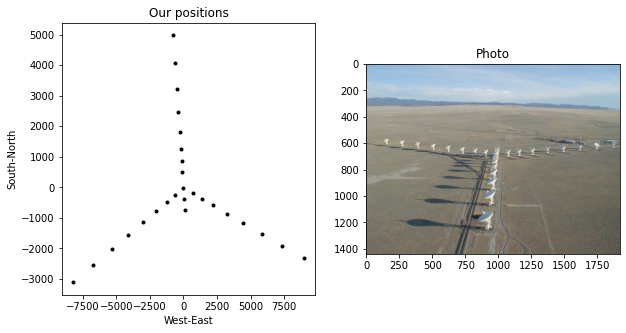

In [7]:
pl.figure(figsize=(10, 5))
pl.subplot(121)
pl.title('Our positions') 
pl.xlabel('West-East') 
pl.ylabel('South-North')
pl.plot(W[:,1], -W[:,0], 'k.', E[:,1], -E[:,0], 'k.', N[:,1], -N[:,0], 'k.')
pl.subplot(122) 
pl.title('Photo') 


response = requests.get('https://public.nrao.edu/wp-content/uploads/2013/09/gallery-images-largeVLASouthAerialWye_large.jpg')
img = Image.open(BytesIO(response.content))
pl.imshow(img)

In [8]:
vla_d = np.vstack((vla_swest,vla_seast,vla_north)) # make a single array of all antenna positions

XYZ_baselines = []                                                                  
for i in range(len(vla_d)):                                                         
    for j in range(i+1,len(vla_d)):
        XYZ_baselines.append(np.subtract(vla_d[i], vla_d[j])) # (u,v)
        XYZ_baselines.append(np.subtract(vla_d[j], vla_d[i])) # (-u,-v)     

XYZ_baselines = np.array(XYZ_baselines)
print("No. of baselines in (u,v) plane:", int(len(XYZ_baselines)/2))

No. of baselines in (u,v) plane: 351


The sampling in Fourier space $(u,v,w)$ is calculated by transforming each XYZ baseline, $\textbf{B}$, into the plane perpendicular to the source direction (i.e. the *projected* baseline) using:

 $\begin{bmatrix}
                 u \\
                 v \\
                 w \\ 
              \end{bmatrix} = \begin{bmatrix} 
        \sin{H} &\cos{H} &0 \\
        -\sin{\delta}\cos{H} &\sin{\delta}\sin{H} &\cos{\delta} \\
        \cos{\delta}\cos{H} &-\cos{\delta}\sin{H} &\sin{\delta} 
     \end{bmatrix} 
 \begin{bmatrix}
                 B_{x} \\
                 B_{y} \\
                 B_{z} \\ 
              \end{bmatrix}$,
              
[Eq. 4.1](https://link.springer.com/chapter/10.1007/978-3-319-44431-4_4) of Thompson, Moran & Swenson.

Here we have defined the source direction ($\textbf{s}$) in terms of its position in Hour Angle ($H$) and declination ($\delta$). Normally astronomical source positions are defined in the [Equatorial co-ordinate system](https://en.wikipedia.org/wiki/Equatorial_coordinate_system) in terms of Right Ascension and declination; the Hour Angle is the angular difference between the Right Ascension ($RA$) of the source and the Local Sidereal Time (LST) at the telescope, which depends on the longitude of the telescope, expressed in hours:

$$HA = LST - RA $$

see [Fig 4.2](https://link.springer.com/chapter/10.1007/978-3-319-44431-4_4) of TMS. 

As the Earth rotates, 15 degrees of the sky will be swept over in one hour. We'll assume that we're making a one hour-long observation, $-0.5 < H < 0.5$, which means that the astronomical pointing direction moves across the local celestial medidian. We'll make a data sample every 6 minutes (0.1 hours).

I'm going to choose a declination for the source direction of $\delta = 45$ degrees. 

**Note:** You might want to investigate how your *uv*-sampling pattern changes if you alter the declination of the source. 

In [9]:
HA = np.arange(-0.5*15.*(np.pi/180.), 0.5*15.*(np.pi/180.), 0.1*(np.pi/180.))  # [radians]
dec = np.pi/4.    

We can calculate the rotation matrix for each step in hour angle:

In [10]:
def calc_R(H,dec):
    
    """
    function to calculate rotation matrix
    """
    
    R = [[np.sin(H), np.cos(H), 0],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec)],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec)]]
    
    return np.array(R)

First let's see how the *uv*-sampling looks for a single time step. We call individual time steps *snapshots*. Note that the numpy library has a built in function for calculating the inner product - very useful!

In [11]:
UV_snapshot=[]
for j in range(len(XYZ_baselines)):
    R = calc_R(0.,dec) # rotation matrix for HA = 0.0
    UV_snapshot.append(np.dot(R, XYZ_baselines[j]))
    
UV_snapshot = np.array(UV_snapshot)

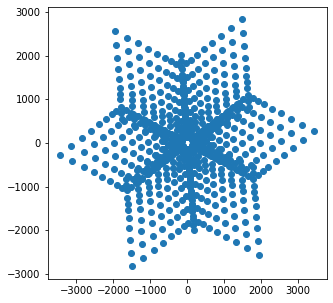

In [12]:
pl.figure(figsize=(5, 5))
pl.scatter(UV_snapshot[:,0],UV_snapshot[:,1])

Now let's look at the uv-coverage for the whole 1 hour observation. We just add in a loop over the hour angle steps:

In [13]:
UV_coverage=[]
for i in range(len(HA)):
    for j in range(len(XYZ_baselines)):
        R = calc_R(HA[i],dec) 
        UV_coverage.append(np.dot(R, XYZ_baselines[j]))
    
UV_coverage = np.array(UV_coverage)

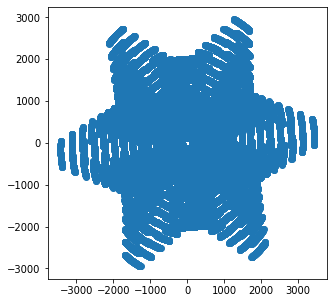

In [14]:
pl.figure(figsize=(5, 5))
pl.scatter(UV_coverage[:,0],UV_coverage[:,1])

**The Point Spread Function**

The first exercise is to calculate the point spread function (PSF), also known as the synthesized beam. To do this we need to grid and FFT our simulated continuous visibilities.

To start with we'll make an empty grid. The pixel size in our uv-grid will determine the field-of-view in the final image and the uv-limit of our grid will determine the pixel size in our final image. So we have to set these carefully.

In [15]:
npix = 256                       # number of pixels on side of grid
# Fourier (uv) space:
uvmax = 4000.
uvcell = 2*uvmax/float(npix)
# image space:
imsize = (1/uvcell)*(180./np.pi)
cellsize = imsize/np.float(npix) # [rads]

Remember that our visibility response is a complex valued function, so we need to make a complex grid:

In [16]:
uvgrid = np.zeros((npix, npix)) + 1j*np.zeros((npix, npix))

We're going to loop through our sample co-ordinates and allocate each one to the nearest pixel in our grid. 

In [17]:
for i in range(UV_coverage.shape[0]):
    u_pixel = int(np.floor(0.5 + UV_coverage[i,0]/uvcell) + npix/2)
    v_pixel = int(np.floor(0.5 + UV_coverage[i,1]/uvcell) + npix/2)
    uvgrid[v_pixel, u_pixel] += 1.0 + 1j*0.0

...and let's plot it. The imaginary part should be zero.

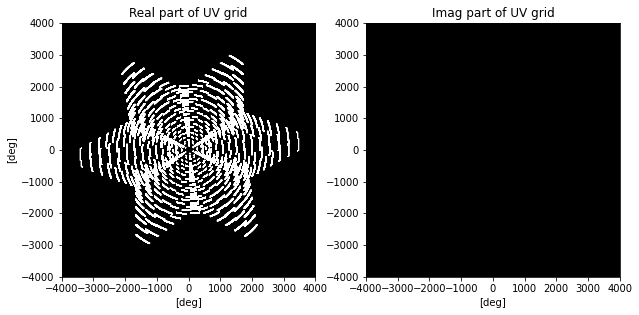

In [18]:
pl.figure(figsize=(10, 10))
pl.subplot(121)
pl.title('Real part of UV grid');
pl.xlabel(r'[deg]');
pl.ylabel(r'[deg]');
pl.imshow(uvgrid.real, origin='lower', vmax = 1, cmap='gray', extent=[-uvmax,uvmax,-uvmax,uvmax])
pl.subplot(122)
pl.title('Imag part of UV grid');
pl.xlabel(r'[deg]');
#pl.ylabel(r'[deg]');
pl.imshow(uvgrid.imag, origin='lower', vmax = 1, cmap='gray', extent=[-uvmax,uvmax,-uvmax,uvmax])

Now we perform the FFT. Two things to note:

* this is an *inverse* FFT, and
* the FFT happens in **two stages**: the first step does a 2d FFT and the second step re-centres the quadrants, this is known as the "FFT shift". 

We haven't bothered to normalise the FFT yet at this point, so we use the peak value of the output to do that.

In [19]:
psf = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(uvgrid)))

fft_norm = np.max(psf.real)
psf/= fft_norm

...and let's see what it looks like. We'll plot the imaginary part too in case there are any artefacts. Note that even if it's worked perfectly the imaginary part will not be identically zero - it will be noisy but at a very low level $(<10^{-10})$ due to the finite precision of the algorithm.

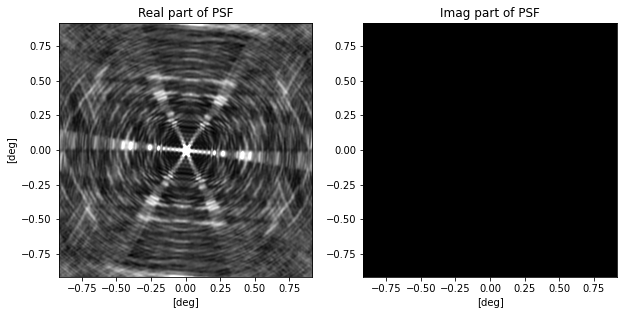

In [20]:
pl.figure(figsize=(10, 10))
pl.subplot(121)
pl.title('Real part of PSF');
pl.xlabel(r'[deg]');
pl.ylabel(r'[deg]');
pl.imshow(psf.real,vmax=0.1,cmap='gray', extent=[-imsize/2,imsize/2,-imsize/2,imsize/2])
pl.subplot(122)
pl.title('Imag part of PSF');
pl.xlabel(r'[deg]');
#pl.ylabel(r'[deg]');
pl.imshow(psf.imag,vmax=0.1,cmap='gray', extent=[-imsize/2,imsize/2,-imsize/2,imsize/2])

----
**The Aliasing Problem**

In this exercise we're going to simulate the response of a telescope to a source *outside the imaged field-of-view*. We're going to see the effect of employing an FFT for imaging without using an anti-aliasing kernel. 

To do this we're going to use a sky brightness distribution that is composed only of compact, i.e. "point-like", radio sources and we're going to calculate the interferometer response analytically.

From the first lecture, you'll have seen that the interferometer response (van Cittert-Zernicke theorem) is given by

$$ V(u,v) = \int{ S(l,m)\, {\rm e}^{-2\pi i(ul + vm)}\,{\rm d}l\,{\rm d}m }.$$

For point-like sources we can say,

$$ S(l,m) = S_0\, \delta(l-l_0, m-m_0), $$

where $S_0$ is the amplitude of the source, which is at location $(l_0,m_0)$. The co-ordinates $(l,m)$ are *direction cosines* on the celestial sphere - basically the separation of the source position from the zero phase point in units of angle.

Our visibility response is therefore:

$$ V(u,v) = \int{ S_0\, \delta(l-l_0, m-m_0)\, {\rm e}^{-2\pi i(ul + vm)}\,{\rm d}l\,{\rm d}m } = S_0\,{\rm e}^{-2\pi i(ul_0 + vm_0)}.$$

For example, say we wanted to calculate the response to a 100 [Jansky](https://en.wikipedia.org/wiki/Jansky) source half a degree away from the phase centre. First we define the source parameters: 

In [21]:
l0 = 0.01; m0 = 0.01    # [rads]
src_lmn = np.array([l0, m0 , np.sqrt(1 - l0**2 - m0**2)-1.])
s0 = 100.0

Then we calculate the visibility response for each baseline's $(u,v,w)$ sample in our snapshot and put them into an array:

In [22]:
V_uv=[]
for i in range(UV_coverage.shape[0]):
    basel_uvw = UV_coverage[i,:]
    vis = s0*np.exp(-2j*np.pi* np.dot(basel_uvw, src_lmn))
    V_uv.append(vis)
    
V_uv = np.array(V_uv)

At this point we have the same kind of data that most radio observatories would deliver to the astronomer who requested the observation: a dataset of *continuous visibilities*, which are regularly sampled in time and frequency.

To make an image from our visibility dataset we need to follow the steps from Lecture 2: we need to grid the visibilities onto a regular grid in $(u,v)$ and then perform an FFT.

Let's start with the gridding. From the lecture, you should remember that we normally need to grid using a convolution kernel to avoid aliasing. Here we're going to demonstrate why this is necessary and ignore the anti-aliasing kernel. We're simply going to grid our visibility data by allocating each sample into the nearest grid cell.

In [23]:
npix = 256                       # number of pixels on side of grid

# Fourier (uv) space:
uvmax = 4000.
uvcell = 2*uvmax/float(npix)

# image space:
imsize = (1/uvcell)*(180./np.pi)
cellsize = imsize/np.float(npix) # [rads]

Just as for the PSF, we need to make a complex grid:

In [24]:
uvgrid2 = np.zeros((npix, npix)) + 1j*np.zeros((npix, npix))

Now let's allocate our continuous visibilities onto the grid:

In [25]:
for i in range(UV_coverage.shape[0]):
    u_pixel = int(np.floor(0.5 + UV_coverage[i,0]/uvcell) + npix/2)
    v_pixel = int(np.floor(0.5 + UV_coverage[i,1]/uvcell) + npix/2)
    uvgrid2[v_pixel, u_pixel] += V_uv[i]

...and see what it looks like:

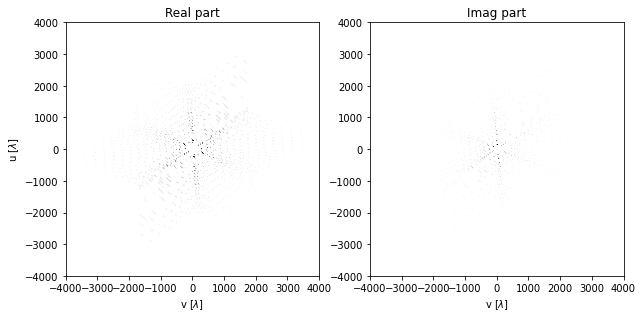

In [26]:
pl.figure(figsize=(10, 10))
pl.subplot(121)
pl.title('Real part');
pl.xlabel(r'v [$\lambda$]');
pl.ylabel(r'u [$\lambda$]');
pl.imshow(uvgrid2.real, origin='lower', vmax = 0.001, cmap='gray', extent=[-uvmax,uvmax,-uvmax,uvmax])
pl.subplot(122)
pl.title('Imag part');
pl.xlabel(r'v [$\lambda$]');
#pl.ylabel(r'u [$\lambda$]');
pl.imshow(uvgrid2.imag, origin='lower', vmax = 1, cmap='gray', extent=[-uvmax,uvmax,-uvmax,uvmax])

Now we can make an image. Remember to normalise it using the value we found from the PSF:

In [27]:
dirty_image = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(uvgrid2)))
dirty_image/= fft_norm

...and let's see what it looks like:

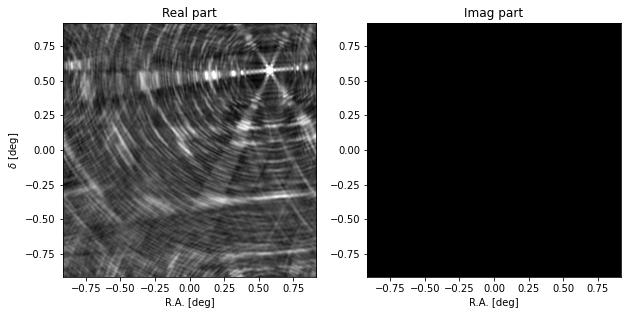

In [28]:
pl.figure(figsize=(10, 10))
pl.subplot(121)
pl.title('Real part');
pl.xlabel(r'R.A. [deg]');
pl.ylabel(r'$\delta$ [deg]');
pl.imshow(dirty_image.real, origin='lower', vmax = 10, cmap='gray', extent=[-imsize/2,imsize/2,-imsize/2,imsize/2])
pl.subplot(122)
pl.title('Imag part');
pl.xlabel(r'R.A. [deg]');
#pl.ylabel(r'$\delta$ [deg]');
pl.imshow(dirty_image.imag, origin='lower', vmax = 10, cmap='gray', extent=[-imsize/2,imsize/2,-imsize/2,imsize/2])

# Deconvolution algorithms 

The true image of the sky can only be obtained if the autocorrelation function has been fully sampled for baseline lengths from zero to infinity and all baseline orientations. Given this problem, worths to ask: what ways are there to improve the estimation of the brightness distribution?


To answer the problems of image quality, the resulting image *Dirty Image* can be improved using deconvolution techniques or mathematical methods seeking to minimize the effect of incomplete sampling.


---



* Maximum Entropy Method (MEM): calculates the image that conforms to the visibilities measured within the noise level, and whose pixel values ​​satisfy the maximum entropy constraint. This method requires calculating the gradient of the objective function in each iteration, so the complexity is a function of the number of samples obtained and the size of the image. In an astronomical context, the use of this algorithm is highly costly in computational time.



---



* CLEAN: This method is used in the production of images and is currently the basis of the official procedure for deconvolution in image synthesis of ALMA
. It uses a simple iterative procedure to find the positions and strengths of these sources. The final deconvolved `CLEAN' image is the sum of:
 
 * These point-source "CLEAN components" reconvolved ( "restored") with a "CLEAN beam" (usually Gaussian) to de-emphasize the higher spatial frequencies which are often spuriously extrapolated and

 * Optionally, but strongly recommended) an image representing residual differences between the point-source model and the data. 

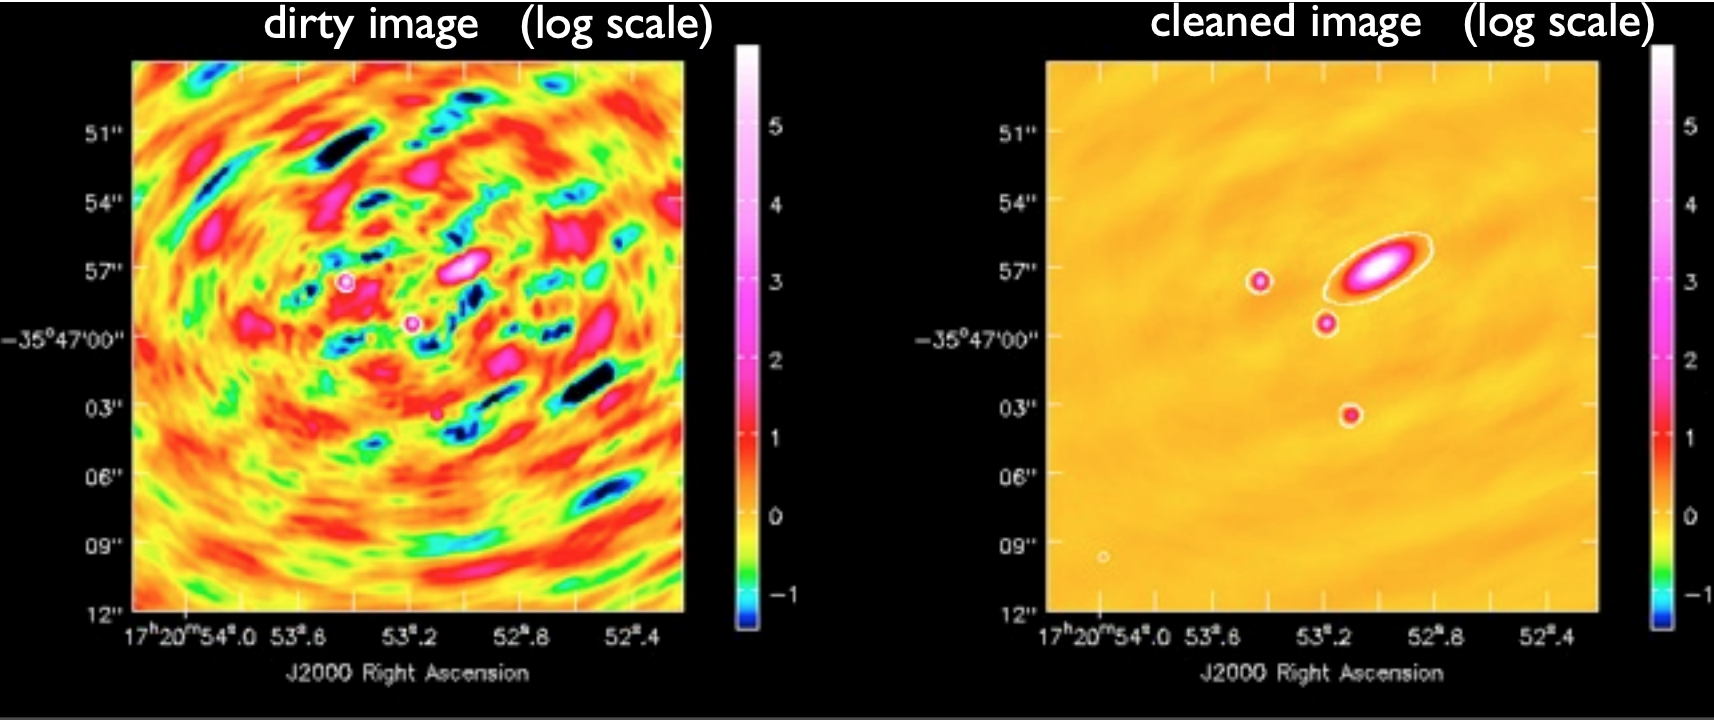




Restauraciones de la Dirty Image utilizando el algoritmo CLEAN, 1000 iteraciónes



---
CLEAN is almost always faster than MEM for small and simple images, but for large and complicated images, such as supernovae at high resolution (up to 100 million pixels), CLEAN is extremely slow, so a MEM type deconvolution is mandatory.




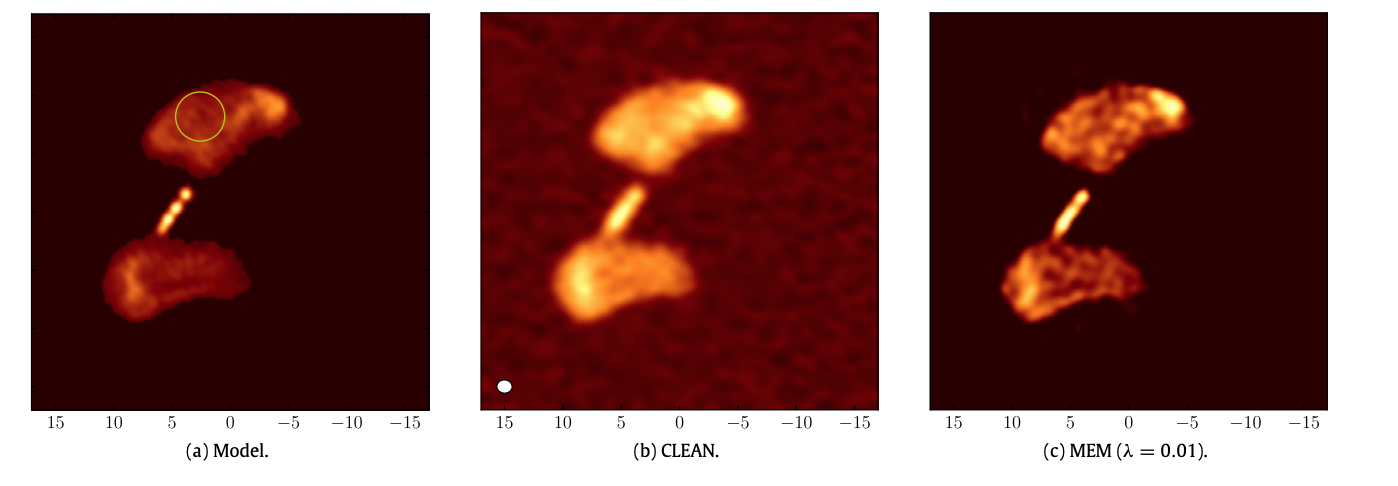


(a) Una versión modelo de la radiogalaxia 3C288 (b) Imagen deconvolucionada con CLEAN (c) Imagen deconvolucionada con MEM

# CASA Sotfware

CASA, the Common Astronomy Software Applications package, is the primary data processing software for the Atacama Large Millimeter/submillimeter Array (ALMA) and NSF's Karl G. Jansky Very Large Array (VLA), and is frequently used also for other radio telescopes. The CASA software can process data from both single-dish and aperture-synthesis telescopes, and one of its core functionalities is to support the data reduction and imaging pipelines for ALMA, VLA and the VLA Sky Survey (VLASS). 

with CASA it is possible to obtain the "Dirty Image" and "Dirty Beam" and the deconvolved image through the "CLEAN" method.



# CONVOLUTIONAL NEURONAL NETWORK FOR IMAGE DECONVOLUTION IN INTERFEROMETRY#

# Motivation

The installation of observatories implies important challenges regarding the software, since it must be capable of storing, processing and enriching the captured data. The software must be able to process amounts of terabytes of data, which allows to improve the images in terms of resolution and sensitivity. These softwares must face the resolution of an important problem: ** the reconstruction of images must be faster and capable of adapting to the measurements made **. This challenge is the reason why research is required in the area of ​​image synthesis.


One of the main problems in interferometry is image deconvolution, which consists of recovering a sharp image, given a blurred image generated by a convolution. In other words, infinite sharp images could produce the same blurry image. Although there are algorithms that try to solve this problem, such as the * CLEAN * algorithm that is currently the basis of the official * ALMA * image synthesis procedure, it is an algorithm that provides suboptimal image quality. the advances that Deep Learning algorithms have had in the area of ​​image reconstruction, is that there is motivation to believe that it is plausible to create a new alternative to classical methods, such as *CLEAN*.


#Expected impact

Current interferometers do not produce images directly, but obtain data that must be processed through expensive hardware and / or specialized software.
This algorithm is expected to be able to produce images faster and less costly than its peers in terms of computation.


The decrease in the time in which the image estimation is performed could allow in the future that the recovery can be carried out on data transmitted in real time. However, the results are not expected to be superior to some of the current methods, but rather, the goal is that they are capable of being considerably faster than their similar methods, with the ability to meet the speed that astronomical observatories need. 


# Research questions


* Using a Convolutional Neural Network, to what extent can the image quality be improved (value given by ** PSNR **), with respect to the *Dirty Image *?


* Using a Convolutional Neural Network, what is the degree of acceleration in execution times with respect to the * MEM * AND * CLEAN * algorithms?


**PSNR**: The Maximum Signal-to-Noise Ratio represents the ratio of the maximum possible energy of a signal to the noise that affects its accurate representation.

 $$ PSNR = 10   \log_{10} (  \frac{MAX_I^2}{MSE}) = 20  \log_{10}(  \frac{MAX_I }{MSE}) $$ 
donde : 

$$ MSE = \frac{1}{MN} \sum_{M-1}^{i=0} \sum_{N-1}^{j=0} \| I(i,j)-K(i,j)\|^2 $$


* $I$ y $k$ pitures with size  $MxN$
* $MAX_I$ the maximum value that a pixel can take in the image.


   



# Images

In [ ]:
from astropy.io import fits
from astropy.utils.data import download_file
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import cv2
import urllib.request as ur
from scipy import ndimage


In [ ]:
##  add padd ## 
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

## Load and process ## 
def load_image(url,width,height,padding):
    url_response= ur.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    w = width-(padding*2)
    h = height-(padding*2)
    dim = (h,w)
    res = cv2.resize(img, dim, interpolation=cv2.INTER_LINEAR)
    res = cv2.normalize(res,None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    res = np.pad(res,padding,pad_with,padder=0)
    return res

**PSF's** 


**PSF real 128x128 cell 0,4**

Filename: /root/.astropy/cache/download/url/dbe13cc871190eb4892e577751e7845c/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      77   (128, 128, 1, 1)   float32   
(1, 1, 128, 128)


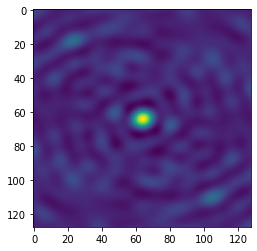

In [ ]:
image_file_128x128_04 = download_file('https://github.com/nicolasalarconl/InterferometryDeepLearning/blob/main/2_hd142_128x128_04.psf.fits?raw=true', cache=True )
hdu_list = fits.open(image_file_128x128_04)
hdu_list.info()
psf_128x128_04 = fits.getdata(image_file_128x128_04)
print(psf_128x128_04.shape)
psf_128x128_04 = np.reshape(psf_128x128_04,[128,128])
plt.imshow(psf_128x128_04)


**PSF real 128x128 cell 0,8**

Filename: /root/.astropy/cache/download/url/423d062de61cc8a03c5869b3ab47e189/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      77   (128, 128, 1, 1)   float32   
(1, 1, 128, 128)


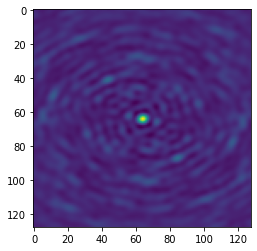

In [ ]:
image_file_128x128_08 = download_file('https://github.com/nicolasalarconl/InterferometryDeepLearning/blob/main/4_hd142_128x128_08.psf.fits?raw=true', cache=True )
hdu_list = fits.open(image_file_128x128_08)
hdu_list.info()
psf_128x128_08 = fits.getdata(image_file_128x128_08)
print(psf_128x128_08.shape)
psf_128x128_08 = np.reshape(psf_128x128_08,[128,128])
plt.imshow(psf_128x128_08)


**PSF Gaussiana 128x128**

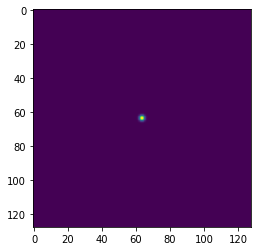

In [ ]:
def gauss(tamX,tamY,div):
  x, y = np.meshgrid(np.linspace(-1,1,tamX), np.linspace(-1,1,tamY))
  d = np.sqrt(x*x+y*y)
  sigma, mu = 1/div, 0.0
  gauss = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
  return gauss

psf_gauss_128x128 =gauss(128,128,64)
plt.imshow(psf_gauss_128x128)

**Interferometry images**

**Interferometry Image 0219JAN12**

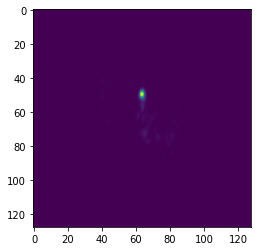

In [ ]:
image_1 = load_image('https://raw.githubusercontent.com/nicolasalarconl/InterferometryDeepLearning/main/0219JAN12.png',128,128,40)
plt.imshow(image_1)

**Interferometry Image 1127JUN08**

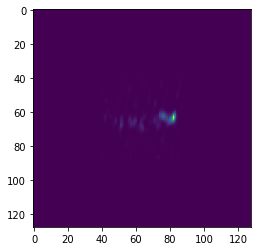

In [ ]:
image_2 = load_image('https://raw.githubusercontent.com/nicolasalarconl/InterferometryDeepLearning/main/1127JUN08.png',128,128,40)
plt.imshow(image_2)

**Convolution**

In [ ]:
# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.show()
    
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()


PSF Gauss  Image 1127JUN08 


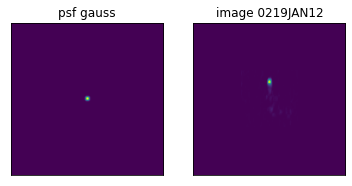

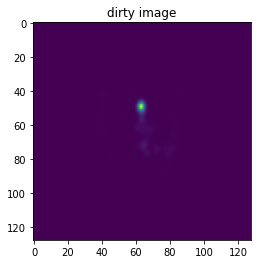

In [ ]:
display(psf_gauss_128x128,image_1,title1="psf gauss",title2="image 0219JAN12")
conv_gauss_fits = ndimage.convolve(image_1,psf_gauss_128x128,mode='constant', cval=0.0)
display_one(conv_gauss_fits,"dirty image")

PSF 128x128 cel 0.8  Image 1127JUN08 


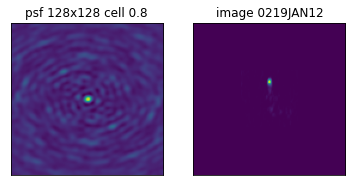

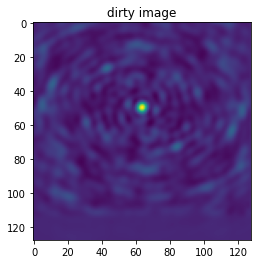

In [ ]:
display(psf_128x128_08,image_1,title1="psf 128x128 cell 0.8",title2="image 0219JAN12")
conv_128x128_08 = ndimage.convolve(image_1,psf_128x128_08,mode='constant', cval=0.0)
display_one(conv_128x128_08,"dirty image")




PSF 128x128 cel 0.4  Image 1127JUN08 


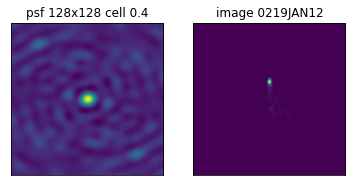

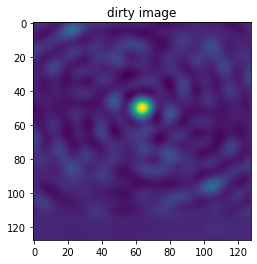

In [ ]:
display(psf_128x128_04,image_1,title1="psf 128x128 cell 0.4",title2="image 0219JAN12")
conv_128x128_04 = ndimage.convolve(image_1,psf_128x128_04,mode='constant', cval=0.0)
display_one(conv_128x128_04,"dirty image")



PSF Gauss  Image Lena 


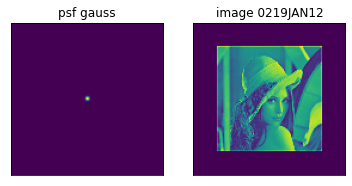

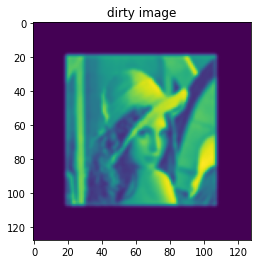

In [ ]:
image_normal = load_image("https://raw.githubusercontent.com/nicolasalarconl/InterferometryDeepLearning/main/Original-Lena-image-512-512-pixels_Q320.jpg",128,128,20)
display(psf_gauss_128x128,image_normal,title1="psf gauss",title2="image 0219JAN12")
conv_gauss_fits = ndimage.convolve(image_normal,psf_gauss_128x128,mode='constant', cval=0.0)
display_one(conv_gauss_fits,"dirty image")

PSF 128x128 cel 0.8  Image Lena 


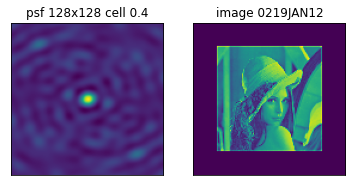

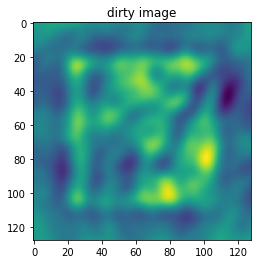

In [ ]:
image_normal = load_image("https://raw.githubusercontent.com/nicolasalarconl/InterferometryDeepLearning/main/Original-Lena-image-512-512-pixels_Q320.jpg",128,128,20)
display(psf_128x128_04,image_normal,title1="psf 128x128 cell 0.4",title2="image 0219JAN12")
conv_128x128_04 = ndimage.convolve(image_normal,psf_128x128_04,mode='constant', cval=0.0)
display_one(conv_128x128_04,"dirty image")



# Print PDF

In [29]:
#instalación
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipa

In [37]:
# Crear archivo de descarga 
from google.colab import drive
drive.mount('/content/drive')

!cp drive/MyDrive/ColabTesis/Resumen.ipynb ./
!jupyter nbconvert --to PDF "Resumen.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[NbConvertApp] Converting notebook Resumen.ipynb to PDF
pandoc: Stack space overflow: current size 33624 bytes.
pandoc: Use `+RTS -Ksize -RTS' to increase it.
[NbConvertApp] Support files will be in Resumen_files/
[NbConvertApp] Making directory ./Resumen_files
[NbConvertApp] Making directory ./Resumen_files
[NbConvertApp] Making directory ./Resumen_files
[NbConvertApp] Making directory ./Resumen_files
[NbConvertApp] Making directory ./Resumen_files
[NbConvertApp] Making directory ./Resumen_files
[NbConvertApp] Making directory ./Resumen_files
[NbConvertApp] Making directory ./Resumen_files
[NbConvertApp] Making directory ./Resumen_files
[NbConvertApp] Making directory ./Resumen_files
[NbConvertApp] Making directory ./Resumen_files
[NbConvertApp] Making directory ./Resumen_files
[NbConvertApp] Making directory ./Resumen_files
[NbConvertApp] Making directory .